In [9]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_CelebA(nn.Module):
    def __init__(self):
        super(CNN_CelebA, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(64),
        transforms.ToTensor()
    ]
)

trainset = CelebA(root='/media/mountHDD2/data', split='train', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = CelebA(root='/media/mountHDD2/data', split='valid', download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = CelebA(root='/media/mountHDD2/data', split='test', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
162770 19867 19962
2544 311 312


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_CelebA().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.30it/s]


Epoch: 0 - TrainRecLoss: 265.3589744148014 - ValidRecLoss: 159.03333556346405
Epoch: 0 - TrainDivLoss: 49.91169319137837 - ValidDivLoss: 44.701434942392204


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.64it/s]


Epoch: 1 - TrainRecLoss: 152.85934949970846 - ValidRecLoss: 138.71493857946152
Epoch: 1 - TrainDivLoss: 45.68886201936494 - ValidDivLoss: 47.25471804692195


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 141.61it/s]


Epoch: 2 - TrainRecLoss: 140.8571391945365 - ValidRecLoss: 129.76690700726633
Epoch: 2 - TrainDivLoss: 48.50405198073237 - ValidDivLoss: 49.949786773094765


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.71it/s]


Epoch: 3 - TrainRecLoss: 133.68183429286165 - ValidRecLoss: 124.9348992567796
Epoch: 3 - TrainDivLoss: 50.0583300980382 - ValidDivLoss: 50.589770659422264


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.66it/s]


Epoch: 4 - TrainRecLoss: 129.13817978804965 - ValidRecLoss: 124.71412228315305
Epoch: 4 - TrainDivLoss: 51.01622760370842 - ValidDivLoss: 51.5772488178351


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.00it/s]


Epoch: 5 - TrainRecLoss: 125.9517488029768 - ValidRecLoss: 122.80860947339963
Epoch: 5 - TrainDivLoss: 51.69780800027667 - ValidDivLoss: 50.0185748002468


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.21it/s]


Epoch: 6 - TrainRecLoss: 123.25659486482728 - ValidRecLoss: 118.91360414945163
Epoch: 6 - TrainDivLoss: 52.2267771996792 - ValidDivLoss: 52.15894104884221


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.16it/s]


Epoch: 7 - TrainRecLoss: 121.08996683996429 - ValidRecLoss: 116.23367639688345
Epoch: 7 - TrainDivLoss: 52.64737954679525 - ValidDivLoss: 52.5261536255861


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 141.45it/s]


Epoch: 8 - TrainRecLoss: 119.68348446732047 - ValidRecLoss: 117.98320740919847
Epoch: 8 - TrainDivLoss: 52.9145990512656 - ValidDivLoss: 52.084831873575844


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.67it/s]


Epoch: 9 - TrainRecLoss: 118.26589798177564 - ValidRecLoss: 114.99926804273557
Epoch: 9 - TrainDivLoss: 53.140624893536355 - ValidDivLoss: 53.58057068555783


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 143.95it/s]


Epoch: 10 - TrainRecLoss: 117.11872896458368 - ValidRecLoss: 113.99646578079614
Epoch: 10 - TrainDivLoss: 53.35731502299039 - ValidDivLoss: 52.6562283100226


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.14it/s]


Epoch: 11 - TrainRecLoss: 116.15919718052606 - ValidRecLoss: 113.10126448900272
Epoch: 11 - TrainDivLoss: 53.49349017413157 - ValidDivLoss: 53.424084357726265


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.46it/s]


Epoch: 12 - TrainRecLoss: 115.35163995454896 - ValidRecLoss: 113.83781041854468
Epoch: 12 - TrainDivLoss: 53.68582851781785 - ValidDivLoss: 53.491706640292435


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.71it/s]


Epoch: 13 - TrainRecLoss: 114.75723327480772 - ValidRecLoss: 112.89504462022047
Epoch: 13 - TrainDivLoss: 53.802884464743755 - ValidDivLoss: 52.89238474919246


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.38it/s]


Epoch: 14 - TrainRecLoss: 114.1352660191134 - ValidRecLoss: 110.7287522829496
Epoch: 14 - TrainDivLoss: 53.921550252902435 - ValidDivLoss: 53.54562321687356


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.57it/s]


Epoch: 15 - TrainRecLoss: 113.66434265232687 - ValidRecLoss: 111.17685462266971
Epoch: 15 - TrainDivLoss: 54.00385902662697 - ValidDivLoss: 53.28511154957307


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.80it/s]


Epoch: 16 - TrainRecLoss: 112.95646485142738 - ValidRecLoss: 110.63675112602039
Epoch: 16 - TrainDivLoss: 54.06396747385181 - ValidDivLoss: 53.938440053890915


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.14it/s]


Epoch: 17 - TrainRecLoss: 112.64242041185967 - ValidRecLoss: 110.31736415471786
Epoch: 17 - TrainDivLoss: 54.15354056328348 - ValidDivLoss: 53.12730157069671


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.76it/s]


Epoch: 18 - TrainRecLoss: 112.20007962400808 - ValidRecLoss: 109.50718397971912
Epoch: 18 - TrainDivLoss: 54.22822286497872 - ValidDivLoss: 54.12399867864755


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.20it/s]


Epoch: 19 - TrainRecLoss: 111.96194121822622 - ValidRecLoss: 108.88223303281345
Epoch: 19 - TrainDivLoss: 54.30376981339365 - ValidDivLoss: 53.93460251734807


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.21it/s]


Epoch: 20 - TrainRecLoss: 111.49392936214711 - ValidRecLoss: 110.1231669890575
Epoch: 20 - TrainDivLoss: 54.369813874082745 - ValidDivLoss: 53.63146245173919


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.06it/s]


Epoch: 21 - TrainRecLoss: 111.28019101964603 - ValidRecLoss: 108.30212715344551
Epoch: 21 - TrainDivLoss: 54.40037900546812 - ValidDivLoss: 54.25487711490729


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.31it/s]


Epoch: 22 - TrainRecLoss: 110.90901305240655 - ValidRecLoss: 109.44571436368503
Epoch: 22 - TrainDivLoss: 54.4765417965703 - ValidDivLoss: 53.87304444190784


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.29it/s]


Epoch: 23 - TrainRecLoss: 110.52648230018856 - ValidRecLoss: 107.68862235240447
Epoch: 23 - TrainDivLoss: 54.51307252967882 - ValidDivLoss: 54.38552770859156


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.91it/s]


Epoch: 24 - TrainRecLoss: 110.39119185741592 - ValidRecLoss: 112.06536806546725
Epoch: 24 - TrainDivLoss: 54.55496713350404 - ValidDivLoss: 54.296747892330856


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.34it/s]


Epoch: 25 - TrainRecLoss: 110.07988675435384 - ValidRecLoss: 109.37203981937506
Epoch: 25 - TrainDivLoss: 54.60033413449173 - ValidDivLoss: 53.142533644651756


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.97it/s]


Epoch: 26 - TrainRecLoss: 109.81002885290661 - ValidRecLoss: 108.69020046331944
Epoch: 26 - TrainDivLoss: 54.67760529608097 - ValidDivLoss: 53.988752976441994


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.43it/s]


Epoch: 27 - TrainRecLoss: 109.58599806731601 - ValidRecLoss: 108.23715789501483
Epoch: 27 - TrainDivLoss: 54.71495884919317 - ValidDivLoss: 54.67814578765478


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.78it/s]


Epoch: 28 - TrainRecLoss: 109.36436537976535 - ValidRecLoss: 107.92342107723921
Epoch: 28 - TrainDivLoss: 54.74673354100881 - ValidDivLoss: 53.86275477287097


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.10it/s]


Epoch: 29 - TrainRecLoss: 109.0666687113684 - ValidRecLoss: 108.49352320646628
Epoch: 29 - TrainDivLoss: 54.75974009022023 - ValidDivLoss: 52.88945661446987


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.14it/s]


Epoch: 30 - TrainRecLoss: 108.96164453554454 - ValidRecLoss: 106.8656897178063
Epoch: 30 - TrainDivLoss: 54.812087337925746 - ValidDivLoss: 54.20561759899824


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.63it/s]


Epoch: 31 - TrainRecLoss: 108.64818458737068 - ValidRecLoss: 108.33185154352432
Epoch: 31 - TrainDivLoss: 54.87820677637304 - ValidDivLoss: 54.12752570861425


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.65it/s]


Epoch: 32 - TrainRecLoss: 108.33958745452593 - ValidRecLoss: 107.48394327897292
Epoch: 32 - TrainDivLoss: 54.9023126206308 - ValidDivLoss: 53.66136998396654


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.50it/s]


Epoch: 33 - TrainRecLoss: 108.11981827058132 - ValidRecLoss: 106.10637498513246
Epoch: 33 - TrainDivLoss: 55.00148594154502 - ValidDivLoss: 54.08465541937412


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.72it/s]


Epoch: 34 - TrainRecLoss: 107.95420911776945 - ValidRecLoss: 106.75395806630452
Epoch: 34 - TrainDivLoss: 55.02270101601223 - ValidDivLoss: 54.20391573050083


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 141.54it/s]


Epoch: 35 - TrainRecLoss: 107.7335564655328 - ValidRecLoss: 105.33377373524202
Epoch: 35 - TrainDivLoss: 55.076926961634896 - ValidDivLoss: 55.33039357112004


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.95it/s]


Epoch: 36 - TrainRecLoss: 107.59363795226474 - ValidRecLoss: 106.35557790902945
Epoch: 36 - TrainDivLoss: 55.111818180144205 - ValidDivLoss: 53.99800312824738


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 142.56it/s]


Epoch: 37 - TrainRecLoss: 107.50889926586511 - ValidRecLoss: 104.2710345341609
Epoch: 37 - TrainDivLoss: 55.1155126979516 - ValidDivLoss: 55.51262185512445


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.77it/s]


Epoch: 38 - TrainRecLoss: 107.28063322163229 - ValidRecLoss: 105.65173158890161
Epoch: 38 - TrainDivLoss: 55.16752481010725 - ValidDivLoss: 54.94062388248933


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.92it/s]


Epoch: 39 - TrainRecLoss: 107.15377681960099 - ValidRecLoss: 105.26034049498729
Epoch: 39 - TrainDivLoss: 55.19631712991487 - ValidDivLoss: 54.663378581022606


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.85it/s]


Epoch: 40 - TrainRecLoss: 106.87853056229885 - ValidRecLoss: 106.26381477942833
Epoch: 40 - TrainDivLoss: 55.237417099610816 - ValidDivLoss: 53.760274862631775


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.65it/s]


Epoch: 41 - TrainRecLoss: 106.81461650320568 - ValidRecLoss: 107.4307431441087
Epoch: 41 - TrainDivLoss: 55.22917599348152 - ValidDivLoss: 53.73717974393796


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.54it/s]


Epoch: 42 - TrainRecLoss: 106.74803230597539 - ValidRecLoss: 104.21043317745894
Epoch: 42 - TrainDivLoss: 55.28636146791326 - ValidDivLoss: 56.27347111090636


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.63it/s]


Epoch: 43 - TrainRecLoss: 106.57124782658224 - ValidRecLoss: 104.93548099811261
Epoch: 43 - TrainDivLoss: 55.29033529233632 - ValidDivLoss: 54.865703289325424


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.75it/s]


Epoch: 44 - TrainRecLoss: 106.42453721784196 - ValidRecLoss: 105.25001789973332
Epoch: 44 - TrainDivLoss: 55.31899285916263 - ValidDivLoss: 54.12648973709498


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.45it/s]


Epoch: 45 - TrainRecLoss: 106.37306263161905 - ValidRecLoss: 105.07795627300555
Epoch: 45 - TrainDivLoss: 55.3321279504764 - ValidDivLoss: 54.58730014165243


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.90it/s]


Epoch: 46 - TrainRecLoss: 106.1729899922257 - ValidRecLoss: 103.73237482706706
Epoch: 46 - TrainDivLoss: 55.327148798876586 - ValidDivLoss: 55.402971622271416


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 142.00it/s]


Epoch: 47 - TrainRecLoss: 106.07175638390787 - ValidRecLoss: 103.21251827631241
Epoch: 47 - TrainDivLoss: 55.34813794699855 - ValidDivLoss: 55.888369633601265


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.06it/s]


Epoch: 48 - TrainRecLoss: 105.96404222872272 - ValidRecLoss: 106.01147681016188
Epoch: 48 - TrainDivLoss: 55.37468623665144 - ValidDivLoss: 54.79766857929719


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.98it/s]


Epoch: 49 - TrainRecLoss: 105.85042104181254 - ValidRecLoss: 104.6013244726719
Epoch: 49 - TrainDivLoss: 55.37587299736791 - ValidDivLoss: 54.466709210322456


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.74it/s]


Epoch: 50 - TrainRecLoss: 105.78061942334445 - ValidRecLoss: 104.39859035687569
Epoch: 50 - TrainDivLoss: 55.42900143929248 - ValidDivLoss: 55.387375966096535


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.85it/s]


Epoch: 51 - TrainRecLoss: 105.6826986576776 - ValidRecLoss: 104.17632983281062
Epoch: 51 - TrainDivLoss: 55.432760160674086 - ValidDivLoss: 55.17467018274161


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.29it/s]


Epoch: 52 - TrainRecLoss: 105.59471090184817 - ValidRecLoss: 105.45106445214687
Epoch: 52 - TrainDivLoss: 55.43300820596563 - ValidDivLoss: 54.184883398887436


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.45it/s]


Epoch: 53 - TrainRecLoss: 105.59765385681729 - ValidRecLoss: 104.39453252156575
Epoch: 53 - TrainDivLoss: 55.431991779579306 - ValidDivLoss: 54.94377282949594


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.11it/s]


Epoch: 54 - TrainRecLoss: 105.368353963648 - ValidRecLoss: 104.07744282942552
Epoch: 54 - TrainDivLoss: 55.4401957988739 - ValidDivLoss: 54.690517841241295


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.83it/s]


Epoch: 55 - TrainRecLoss: 105.4168324230602 - ValidRecLoss: 104.8109734364045
Epoch: 55 - TrainDivLoss: 55.46981150399214 - ValidDivLoss: 55.26819160657051


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.20it/s]


Epoch: 56 - TrainRecLoss: 105.3315095061776 - ValidRecLoss: 104.41755231221516
Epoch: 56 - TrainDivLoss: 55.470139587450326 - ValidDivLoss: 54.81083349081186


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.37it/s]


Epoch: 57 - TrainRecLoss: 105.17857092431507 - ValidRecLoss: 103.10817972819011
Epoch: 57 - TrainDivLoss: 55.46891223409641 - ValidDivLoss: 55.45445905587612


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.84it/s]


Epoch: 58 - TrainRecLoss: 105.1448489315105 - ValidRecLoss: 104.62858772277832
Epoch: 58 - TrainDivLoss: 55.4651628950107 - ValidDivLoss: 54.510337132673996


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.33it/s]


Epoch: 59 - TrainRecLoss: 105.08991217163374 - ValidRecLoss: 103.38032341003418
Epoch: 59 - TrainDivLoss: 55.4873555636256 - ValidDivLoss: 55.182139946864204


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.95it/s]


Epoch: 60 - TrainRecLoss: 104.90183489877472 - ValidRecLoss: 105.27971145434257
Epoch: 60 - TrainDivLoss: 55.50015106141193 - ValidDivLoss: 54.693979177719505


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 141.20it/s]


Epoch: 61 - TrainRecLoss: 105.00058270700323 - ValidRecLoss: 101.7454918592404
Epoch: 61 - TrainDivLoss: 55.5181537724141 - ValidDivLoss: 56.42484444838304


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.56it/s]


Epoch: 62 - TrainRecLoss: 104.92276903968187 - ValidRecLoss: 103.06768170381204
Epoch: 62 - TrainDivLoss: 55.51856491550709 - ValidDivLoss: 55.870265202644546


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.74it/s]


Epoch: 63 - TrainRecLoss: 104.80724955804693 - ValidRecLoss: 104.67821094317314
Epoch: 63 - TrainDivLoss: 55.52620215086067 - ValidDivLoss: 54.185180028279625


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.95it/s]


Epoch: 64 - TrainRecLoss: 104.59745067020633 - ValidRecLoss: 104.92714339036208
Epoch: 64 - TrainDivLoss: 55.55625788520717 - ValidDivLoss: 54.78581152206812


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.47it/s]


Epoch: 65 - TrainRecLoss: 104.69944992305348 - ValidRecLoss: 103.99470334175305
Epoch: 65 - TrainDivLoss: 55.52677062472458 - ValidDivLoss: 54.675315245603905


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.74it/s]


Epoch: 66 - TrainRecLoss: 104.5713206627084 - ValidRecLoss: 102.82088541373228
Epoch: 66 - TrainDivLoss: 55.554036269397855 - ValidDivLoss: 54.85137155728462


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.73it/s]


Epoch: 67 - TrainRecLoss: 104.50193014684713 - ValidRecLoss: 104.22712171994723
Epoch: 67 - TrainDivLoss: 55.565648369819115 - ValidDivLoss: 54.507196707603256


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 133.74it/s]


Epoch: 68 - TrainRecLoss: 104.45193369283616 - ValidRecLoss: 104.12376702137483
Epoch: 68 - TrainDivLoss: 55.564564794864296 - ValidDivLoss: 54.19692357381185


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.17it/s]


Epoch: 69 - TrainRecLoss: 104.43916562518234 - ValidRecLoss: 103.46051282149095
Epoch: 69 - TrainDivLoss: 55.55796812165458 - ValidDivLoss: 54.78969242633917


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 142.49it/s]


Epoch: 70 - TrainRecLoss: 104.4383818218543 - ValidRecLoss: 104.40301731305244
Epoch: 70 - TrainDivLoss: 55.58653805390844 - ValidDivLoss: 54.75325281192095


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.56it/s]


Epoch: 71 - TrainRecLoss: 104.24015578983715 - ValidRecLoss: 104.40645907475398
Epoch: 71 - TrainDivLoss: 55.589752068309664 - ValidDivLoss: 54.0604561659006


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.65it/s]


Epoch: 72 - TrainRecLoss: 104.23298443488355 - ValidRecLoss: 103.62195002727019
Epoch: 72 - TrainDivLoss: 55.59440900394752 - ValidDivLoss: 55.28107722600301


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.42it/s]


Epoch: 73 - TrainRecLoss: 104.20328213733697 - ValidRecLoss: 102.80404237600473
Epoch: 73 - TrainDivLoss: 55.557877198705135 - ValidDivLoss: 54.97222944406363


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.47it/s]


Epoch: 74 - TrainRecLoss: 104.14510751220415 - ValidRecLoss: 103.78203470279009
Epoch: 74 - TrainDivLoss: 55.568280483941614 - ValidDivLoss: 54.291736737275734


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.07it/s]


Epoch: 75 - TrainRecLoss: 104.17637998952806 - ValidRecLoss: 103.26013036874625
Epoch: 75 - TrainDivLoss: 55.594738240511916 - ValidDivLoss: 54.95687142396584


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.29it/s]


Epoch: 76 - TrainRecLoss: 103.9827296149056 - ValidRecLoss: 103.76725507393861
Epoch: 76 - TrainDivLoss: 55.56486934835806 - ValidDivLoss: 54.51287600932977


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.75it/s]


Epoch: 77 - TrainRecLoss: 104.0423981918479 - ValidRecLoss: 102.29429577558469
Epoch: 77 - TrainDivLoss: 55.58944666760522 - ValidDivLoss: 56.32414476688091


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.29it/s]


Epoch: 78 - TrainRecLoss: 103.98846921081063 - ValidRecLoss: 101.862809914809
Epoch: 78 - TrainDivLoss: 55.57858672381947 - ValidDivLoss: 56.02561501967601


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.41it/s]


Epoch: 79 - TrainRecLoss: 103.96954214347983 - ValidRecLoss: 103.89842559129764
Epoch: 79 - TrainDivLoss: 55.598584828886594 - ValidDivLoss: 55.47983745428232


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.12it/s]


Epoch: 80 - TrainRecLoss: 103.92479149200632 - ValidRecLoss: 104.74402909401135
Epoch: 80 - TrainDivLoss: 55.61537577970972 - ValidDivLoss: 54.71932653280405


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.81it/s]


Epoch: 81 - TrainRecLoss: 103.84578334460468 - ValidRecLoss: 103.95437820141132
Epoch: 81 - TrainDivLoss: 55.615942049326385 - ValidDivLoss: 54.53714812107575


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.09it/s]


Epoch: 82 - TrainRecLoss: 103.83376744408278 - ValidRecLoss: 101.87501225104698
Epoch: 82 - TrainDivLoss: 55.63931465748721 - ValidDivLoss: 55.248563913198616


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.38it/s]


Epoch: 83 - TrainRecLoss: 103.80923945948763 - ValidRecLoss: 103.18527116530981
Epoch: 83 - TrainDivLoss: 55.63079449965519 - ValidDivLoss: 54.40998949148716


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 132.73it/s]


Epoch: 84 - TrainRecLoss: 103.68396060271833 - ValidRecLoss: 103.43483717013628
Epoch: 84 - TrainDivLoss: 55.61663551750423 - ValidDivLoss: 55.08930113376715


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.95it/s]


Epoch: 85 - TrainRecLoss: 103.73076307248769 - ValidRecLoss: 102.54647125341954
Epoch: 85 - TrainDivLoss: 55.59795233288651 - ValidDivLoss: 54.786056115077095


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.73it/s]


Epoch: 86 - TrainRecLoss: 103.56504508984163 - ValidRecLoss: 102.85546102279272
Epoch: 86 - TrainDivLoss: 55.62158183031862 - ValidDivLoss: 54.90254603899442


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.28it/s]


Epoch: 87 - TrainRecLoss: 103.55745989721527 - ValidRecLoss: 101.69198627960988
Epoch: 87 - TrainDivLoss: 55.64531485089716 - ValidDivLoss: 55.66590037712684


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 137.56it/s]


Epoch: 88 - TrainRecLoss: 103.6193367820116 - ValidRecLoss: 103.24082704690787
Epoch: 88 - TrainDivLoss: 55.634876092274986 - ValidDivLoss: 54.79760542894021


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 138.77it/s]


Epoch: 89 - TrainRecLoss: 103.53652659902033 - ValidRecLoss: 102.26922854399069
Epoch: 89 - TrainDivLoss: 55.64851019517431 - ValidDivLoss: 55.53663277014708


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.25it/s]


Epoch: 90 - TrainRecLoss: 103.54432855762026 - ValidRecLoss: 102.93387254079182
Epoch: 90 - TrainDivLoss: 55.65166579552417 - ValidDivLoss: 55.60972125713642


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.42it/s]


Epoch: 91 - TrainRecLoss: 103.46825501603901 - ValidRecLoss: 102.28057098388672
Epoch: 91 - TrainDivLoss: 55.642427143060935 - ValidDivLoss: 55.674052629715355


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 140.46it/s]


Epoch: 92 - TrainRecLoss: 103.38829833756454 - ValidRecLoss: 102.91633439675356
Epoch: 92 - TrainDivLoss: 55.65471779925269 - ValidDivLoss: 55.034636094019966


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 139.05it/s]


Epoch: 93 - TrainRecLoss: 103.32383698937278 - ValidRecLoss: 102.99109388009096
Epoch: 93 - TrainDivLoss: 55.66308769340035 - ValidDivLoss: 54.927449409778305


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 135.94it/s]


Epoch: 94 - TrainRecLoss: 103.30349505022637 - ValidRecLoss: 104.22931059812888
Epoch: 94 - TrainDivLoss: 55.664950027405844 - ValidDivLoss: 54.93547554505177


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.73it/s]


Epoch: 95 - TrainRecLoss: 103.29014920288662 - ValidRecLoss: 101.97181784800993
Epoch: 95 - TrainDivLoss: 55.697865315203394 - ValidDivLoss: 55.543040703504516


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 134.95it/s]


Epoch: 96 - TrainRecLoss: 103.21625080648458 - ValidRecLoss: 102.64121735401643
Epoch: 96 - TrainDivLoss: 55.66326000855404 - ValidDivLoss: 55.26792004169562


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 132.40it/s]


Epoch: 97 - TrainRecLoss: 103.19792846163864 - ValidRecLoss: 103.34989391229091
Epoch: 97 - TrainDivLoss: 55.670782231684754 - ValidDivLoss: 55.06541124979655


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 142.57it/s]


Epoch: 98 - TrainRecLoss: 103.19129570775063 - ValidRecLoss: 101.9953674414219
Epoch: 98 - TrainDivLoss: 55.68241531893892 - ValidDivLoss: 55.617568407303246


100%|████████████████████████████████████████████████████████████████| 312/312 [00:02<00:00, 136.08it/s]

Epoch: 99 - TrainRecLoss: 103.16606880583853 - ValidRecLoss: 104.84265422821045
Epoch: 99 - TrainDivLoss: 55.68145197892339 - ValidDivLoss: 54.455518086751304


In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

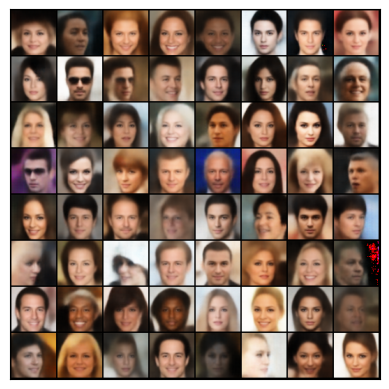

In [13]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

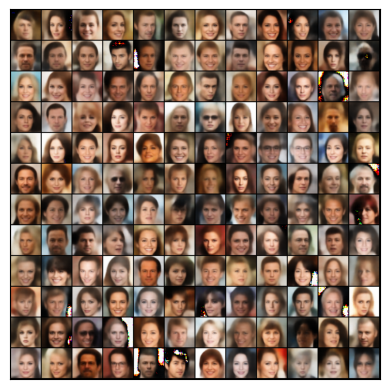

In [16]:
z = torch.randn(144, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)